In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D


Using TensorFlow backend.


In [3]:
# Read MFCCs feature CSV file of audio of 100ms block

path="./home/bsplab/Desktop/manikanta/CNN_mani/Traing_100ms/CRYING/"
#filename=os.path.join(path,"100ms_7C.csv")
traindata =pd.read_csv("/home/bsplab/Desktop/manikanta/CNN_mani/Traing_100ms/CRYING/individual_100ms.csv",na_values=['NA','?'])
traindata .columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
#df=pd.read_csv(filename,na_values=['NA','?'])
filename_write = os.path.join(path,"individual_100ms_cnn.csv.csv")
print(traindata .shape)
traindata .head()

(575983, 14)


,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-10.339339,-58.503360,28.969193,-16.135848,-0.850935,-7.166208,24.007454,-25.177117,7.820241,1.586773,-0.016230,-4.160415,-2.928838,crying
1,-10.255503,-58.766382,28.839630,-15.665957,0.201420,-7.582272,24.395316,-24.310047,9.044284,1.180245,1.338979,-2.547351,-3.876356,crying
2,-10.219711,-47.300163,29.763146,-17.593168,3.772775,-9.047093,18.010719,-21.991444,12.146181,-2.855262,-0.514320,-0.502388,-3.394465,crying
3,-10.335775,-36.359484,28.162880,-7.049695,27.120645,-3.100069,16.331104,-2.871143,28.954943,-1.509898,1.557353,5.172644,-2.621226,crying
4,-10.328217,-20.086843,13.868843,-5.345090,23.884885,-9.032826,10.503083,0.159714,21.487532,-3.494115,4.201391,3.049172,6.644954,crying


In [4]:
traindata=traindata.dropna()
traindata.shape

(575983, 14)

In [5]:
# Shuffle
np.random.seed(42)# set a seed so that the results are consistent
traindata = traindata.reindex(np.random.permutation(traindata.index))
traindata.reset_index(inplace=True, drop=True)
traindata.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-5.604626,-8.172296,5.206748,-2.383627,-21.005279,16.550854,-22.240188,-2.184232,17.962110,-38.702665,30.683808,-23.026454,4.921159,speech
1,-1.771606,13.864471,-32.058541,10.250745,-21.167710,8.608871,-22.244622,-18.606278,2.309756,-15.449925,3.155800,-9.158134,3.111149,music
2,-2.758959,-6.394277,2.617576,1.732703,-27.661945,29.846086,-30.306968,0.760964,20.359883,-40.511891,41.736541,-25.518602,14.693751,speech
3,-3.917437,14.327343,-16.532813,0.810541,-12.540902,9.442987,-25.251732,-29.238576,10.375724,-26.777831,4.799518,-8.528685,-3.050550,music
4,-1.644729,-37.392616,-1.961913,48.395111,-30.597397,34.214259,8.289310,-25.629234,-2.689849,-10.126319,-8.749178,4.808536,-10.116423,speech


In [6]:
# Encode to a 2D matrix for training
Label = encode_text_index(traindata,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(traindata,'Label')

Labelling is:['ac' 'crying' 'music' 'speech']


/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [7]:
X = traindata.iloc[:,0:13]
Y = traindata.iloc[:,13]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [9]:
trainX = np.array(X_train)
testT = np.array(X_test)

In [10]:
y_train1 = np.array(y_train)
y_test1 = np.array(y_test)

In [11]:
#import keras
#import keras.utils
from keras.utils import to_categorical
from keras import utils as np_utils
y_train= to_categorical(y_train1)
y_test= to_categorical(y_test1)

In [12]:
X_train = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
X_test = np.reshape(testT, (testT.shape[0],testT.shape[1],1))

In [52]:
X_train.shape

(431987, 13, 1)

In [53]:
X_test.shape

(143996, 13, 1)

In [13]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [14]:
cnn = Sequential()
cnn.add(Convolution1D(64, 3, border_mode="same",activation="relu",input_shape=(13,1)))
cnn.add(MaxPooling1D(pool_length=(2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(4, activation="softmax"))

/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", input_shape=(13, 1), padding="same")`
  
/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

# train
checkpointer = callbacks.ModelCheckpoint(filepath="/home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='loss')
csv_logger = CSVLogger('/home/bsplab/Desktop/manikanta/CNN_mani/logs/output1.csv',separator=',', append=False)
cnn.fit(X_train, y_train, nb_epoch=100,batch_size=128,callbacks=[checkpointer,csv_logger])
cnn.save("/home/bsplab/Desktop/manikanta/CNN_mani/logs/cnn_mcsvfile.hdf5")

/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/100
431987/431987 [==============================] - 10s 24us/step - loss: 0.1448 - acc: 0.9515

Epoch 00001: loss improved from inf to 0.14483, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-01.hdf5
Epoch 2/100
431987/431987 [==============================] - 9s 22us/step - loss: 0.1028 - acc: 0.9648

Epoch 00002: loss improved from 0.14483 to 0.10281, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-02.hdf5
Epoch 3/100
431987/431987 [==============================] - 9s 21us/step - loss: 0.0917 - acc: 0.9693

Epoch 00003: loss improved from 0.10281 to 0.09175, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-03.hdf5
Epoch 4/100
431987/431987 [==============================] - 10s 22us/step - loss: 0.0850 - acc: 0.9714

Epoch 00004: loss improved from 0.09175 to 0.08504, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-04.hdf5
Epoch 5/100
431987/431987 [==============================]

431987/431987 [==============================] - 9s 21us/step - loss: 0.0492 - acc: 0.9837

Epoch 00037: loss did not improve from 0.04916
Epoch 38/100
431987/431987 [==============================] - 10s 22us/step - loss: 0.0480 - acc: 0.9840

Epoch 00038: loss improved from 0.04916 to 0.04800, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-38.hdf5
Epoch 39/100
431987/431987 [==============================] - 9s 22us/step - loss: 0.0482 - acc: 0.9840

Epoch 00039: loss did not improve from 0.04800
Epoch 40/100
431987/431987 [==============================] - 9s 22us/step - loss: 0.0480 - acc: 0.9842

Epoch 00040: loss improved from 0.04800 to 0.04796, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-40.hdf5
Epoch 41/100
431987/431987 [==============================] - 10s 23us/step - loss: 0.0477 - acc: 0.9843

Epoch 00041: loss improved from 0.04796 to 0.04766, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-41.h

431987/431987 [==============================] - 9s 22us/step - loss: 0.0415 - acc: 0.9864

Epoch 00078: loss improved from 0.04162 to 0.04150, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-78.hdf5
Epoch 79/100
431987/431987 [==============================] - 10s 23us/step - loss: 0.0421 - acc: 0.9861

Epoch 00079: loss did not improve from 0.04150
Epoch 80/100
431987/431987 [==============================] - 10s 24us/step - loss: 0.0421 - acc: 0.9862

Epoch 00080: loss did not improve from 0.04150
Epoch 81/100
431987/431987 [==============================] - 10s 23us/step - loss: 0.0413 - acc: 0.9862

Epoch 00081: loss improved from 0.04150 to 0.04129, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-81.hdf5
Epoch 82/100
431987/431987 [==============================] - 10s 23us/step - loss: 0.0412 - acc: 0.9859

Epoch 00082: loss improved from 0.04129 to 0.04125, saving model to /home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-82

In [16]:
import time
tic = time.time()
#model.save('manikanta_FeedforwardNN_4class.h5')
cnn.save("/home/bsplab/Desktop/manikanta/CNN_mani/logs/cnn_mcsvfile.hdf5")
toc = time.time()
print(str(1000*(toc-tic))+"ms")

21.076202392578125ms


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [19]:
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
cnn.load_weights("/home/bsplab/Desktop/manikanta/CNN_mani/logs/checkpoint-96.hdf5")

y_pred = cnn.predict_classes(X_test)
accuracy = accuracy_score(y_test1, y_pred)
recall = recall_score(y_test1, y_pred , average="weighted")
precision = precision_score(y_test1, y_pred , average="weighted")
f1 = f1_score(y_test1, y_pred, average="weighted")

print("----------------------------------------------")
print("acc")
print("%.3f" %accuracy)
print("rec")
print("%.3f" %recall)
print("pre")
print("%.3f" %precision)
print("f1")
print("%.3f" %f1)
cm = metrics.confusion_matrix(y_test1, y_pred)
print("==============================================")
print(cm)

----------------------------------------------
acc
0.991
rec
0.991
pre
0.991
f1
0.991
[[35873     1     0     3]
 [    3 35481   178   179]
 [    3   225 35682   214]
 [    2   231   250 35671]]


test confusion matrix
[[35873     1     0     3]
 [    3 35481   178   179]
 [    3   225 35682   214]
 [    2   231   250 35671]]


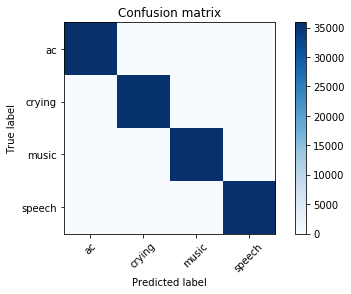

In [20]:
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_test1, y_pred)
np.set_printoptions(precision=2)
print('test confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_cnn100ms.png',dpi=150)
plt.savefig('cm_cnn100ms.eps',dpi=150)

Confusion matrix, without normalization


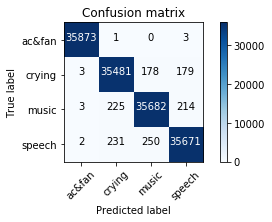

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test1, y_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['ac&fan', 'crying','music', 'speech'],
                      title='Confusion matrix')

plt.savefig('cnn_confusiponmatrix.png')

New data without labeling

In [22]:
from keras.models import load_model

In [23]:
loaded_mymodel= load_model('/home/bsplab/Desktop/manikanta/CNN_mani/logs/cnn_mcsvfile.hdf5')
print(loaded_mymodel)


In [24]:
traindata1 = pd.read_csv('/home/bsplab/Desktop/manikanta/CNN_mani/Testing_100ms/CRYING/crying_testing.csv')
traindata1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
traindata1.head()
print(traindata1)
#traindata1.shape()


           MFCC0      MFCC1      MFCC2      MFCC3      MFCC4      MFCC5  \
0     -10.166330 -28.840257 -37.230772  14.160532 -10.673806   3.915022   
1      -9.132246 -28.308959 -39.586994  19.144334 -16.303967   6.448080   
2      -8.793318 -26.725370 -39.885100  14.762905 -21.725920   8.523211   
3      -8.566548 -25.436487 -37.422073  14.051592 -29.393727   5.823137   
4      -8.246559 -25.085498 -33.691972  18.270865 -35.307783   4.511325   
5      -8.385470 -24.419451 -30.187452  18.560805 -34.559994   5.771957   
6      -6.111275 -11.863153 -31.854287 -10.497121  -8.960644  28.290933   
7      -2.948489 -13.609883 -49.967322   0.260375 -30.381663  47.969950   
8       0.315184 -23.868377 -55.227601  -6.038735 -33.850086  46.549432   
9       2.073974 -16.809247 -59.017832  -9.488300 -52.757944  25.484973   
10      1.904706 -16.616180 -57.005626 -11.271170 -50.117561  21.366501   
11      1.136662  -9.852493 -45.346100 -11.356098 -38.836975 -21.744510   
12      2.210976  -6.4818

In [25]:
traindata1 = traindata1.values.reshape((71997,13, 1))

In [26]:
tic = time.time()
my_his=loaded_mymodel.predict(traindata1)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


2240.3411865234375ms


(71997, 4)

In [27]:
test_pred = np.argmax(my_his, axis=1)
test_pred[150:380]
print(test_pred.shape)


(71997,)


In [28]:
test_pred.dtype

dtype('int64')

In [30]:
c =0
for i in  test_pred:
    if i== 1:
         c += 1
    else:
        continue 
if c > test_pred.size/2:
    print("The tested audio is Crying")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is Crying
Count is 65352


In [31]:
TP=sum(test_pred==0)
TP

7

In [32]:
x=c/test_pred.size
print('Accuracy is for testing with new environment data of Crying:',100*x)

Accuracy is for testing with new environment data of Crying: 90.7704487686987


In [33]:
traindata2 = pd.read_csv('/home/bsplab/Desktop/manikanta/CNN_mani/Testing_100ms/FAN_AC/acfan_testing.csv')
traindata2.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
traindata2.head()
print(traindata2)

          MFCC0      MFCC1      MFCC2      MFCC3      MFCC4      MFCC5  \
0     -2.136286  18.082098  23.966619  12.068622  23.338320   1.779057   
1     -2.784024  11.827223  30.342649  24.918855  35.260922  -0.852137   
2     -2.011540  19.497970  27.626973  18.961353  25.172313   0.991883   
3     -1.705295  18.844853  32.961204  25.221247  23.003481  -2.676496   
4     -2.508776  16.997048  25.543736  15.155044  23.828525   1.319310   
5     -2.570069  15.296549  34.875984  23.323626  36.451120  -3.948590   
6     -2.382347  17.494129  34.734297  19.386687  32.851699  -4.893888   
7     -2.858220  18.167974  29.307810  14.637984  29.665675  -6.541302   
8     -3.252421  14.095501  31.839132  22.395343  32.731965  -5.737017   
9     -3.753252   8.264461  21.386039  22.333784  24.381523   1.801821   
10    -3.034050   8.792350  25.561422  29.225604  29.949117   1.928972   
11    -2.771499  15.087171  35.067742  24.434670  35.102429  -7.296454   
12    -2.175525  13.734832  31.803575 

In [34]:
traindata2 = traindata2.values.reshape((71997,13, 1))

In [35]:
tic = time.time()
my_his=loaded_mymodel.predict(traindata2)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


2181.574821472168ms


(71997, 4)

In [36]:
test_pred1 = np.argmax(my_his, axis=1)
test_pred1[150:380]
print(test_pred1.shape)

(71997,)


In [37]:
c =0
for i in  test_pred1:
    if i== 0:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is fan&ac")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is fan&ac
Count is 55605


In [38]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of fan&ac:',100*x)

Accuracy is for testing with new environment data of fan&ac: 77.23238468269511


In [39]:
traindata3 = pd.read_csv('/home/bsplab/Desktop/manikanta/CNN_mani/Testing_100ms/MUSIC/music_testing.csv')
traindata3.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
traindata3.head()
print(traindata3)

          MFCC0      MFCC1      MFCC2      MFCC3      MFCC4      MFCC5  \
0     -2.847183  -5.133256 -29.495073   3.365811  11.383593 -24.462942   
1     -2.725085  -5.417088 -30.142874   3.098088   9.144453 -24.416763   
2     -2.778715  -4.654355 -28.830765   4.670435   8.786832 -24.033239   
3     -3.120197  -3.893042 -26.895662   3.886940   9.120508 -27.681915   
4     -3.296787  -1.758949 -27.415814  -3.500055   2.782435 -29.642224   
5     -2.619572  -0.484542 -35.122168  -9.848952   6.579182 -27.464498   
6     -2.006199   0.398312 -38.787543 -10.754957   9.910351 -27.914611   
7     -1.790863   0.664360 -40.456315  -7.478029  12.454894 -28.315719   
8     -1.592627   0.577481 -42.793775  -9.321924   5.978363 -27.194942   
9     -1.626863  -0.878060 -43.632081 -10.866416   0.530722 -26.341613   
10    -1.564313  -0.796536 -41.666007  -6.572404   1.356740 -27.446241   
11    -1.329345   1.772174 -38.369225  -4.905178  -0.092203 -32.970199   
12    -1.456944  -0.698208 -37.239966 

In [40]:
traindata3 = traindata3.values.reshape((71997,13, 1))

In [41]:
tic = time.time()
my_his=loaded_mymodel.predict(traindata3)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


2050.652027130127ms


(71997, 4)

In [42]:
test_pred2 = np.argmax(my_his, axis=1)
test_pred2[150:380]
print(test_pred2.shape)

(71997,)


In [43]:
c =0
for i in  test_pred2:
    if i== 2:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is music")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is music
Count is 66321


In [44]:
x=c/test_pred2.size
print('Accuracy is for testing with new environment data of music:',100*x)

Accuracy is for testing with new environment data of music: 92.11633818075752


In [45]:
traindata4 = pd.read_csv('/home/bsplab/Desktop/manikanta/CNN_mani/Testing_100ms/SPEECH/speech_testing.csv')
traindata4.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
traindata4.head()
print(traindata4)

          MFCC0      MFCC1      MFCC2      MFCC3      MFCC4      MFCC5  \
0     -1.913532  31.852519 -42.577216 -18.321822  -8.708340 -12.481428   
1     -5.118569  33.345421 -30.475053   2.577803   5.102440 -21.529671   
2     -7.092314  25.187206 -19.243648   3.264571  18.508959  -0.360402   
3     -4.847582  32.435658  -7.349611  12.984855  19.569092  -6.030120   
4     -4.120471  35.838699  -7.079418   6.508375  12.518670 -16.737157   
5     -3.859222  42.890352 -18.126388  -1.586541   2.517144 -37.993624   
6     -3.464434  36.924635 -16.566608  -8.345801  -6.749671 -38.803027   
7     -3.547884  47.197588 -21.393149  -9.016009   2.898986 -47.028028   
8     -4.155614  32.140166 -15.141683   3.418134  10.387392 -21.771469   
9     -3.984728  37.820340 -30.483679  15.234969  32.531250 -27.073074   
10    -3.663392  31.851781 -28.837347  15.175058  30.364914 -18.518461   
11    -3.906725  34.374503 -35.363530  14.892589  38.573227 -31.246310   
12    -4.726873  15.959966 -21.162888 

In [46]:
traindata4 = traindata4.values.reshape((71997,13, 1))

In [47]:
tic = time.time()
my_his=loaded_mymodel.predict(traindata4)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


2256.307363510132ms


(71997, 4)

In [48]:
test_pred3 = np.argmax(my_his, axis=1)
test_pred3[150:380]
print(test_pred3.shape)

(71997,)


In [49]:
c =0
for i in  test_pred3:
    if i== 3:
         c += 1
    else:
        continue 
if c > test_pred3.size/2:
    print("The tested audio is speech")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is speech
Count is 61302


In [50]:
x=c/test_pred3.size
print('Accuracy is for testing with new environment data of speech:',100*x)

Accuracy is for testing with new environment data of speech: 85.14521438393267
